# Resnets

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/timaeus-research/devinterp/blob/main/examples/resnets.ipynb)

In [1]:
# %pip install devinterp matplotlib seaborn torchvision

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import optim, nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from devinterp.slt import estimate_learning_coeff
from devinterp.optim.sgld import SGLD

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available()
                       else "cpu")

In [3]:
# Transform to imagenet format
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.244, 0.225]),
    ]
)

trainset = datasets.CIFAR10(root="../data", train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root="../data", train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=256, shuffle=True)
testloader = DataLoader(testset, batch_size=256, shuffle=False)

100%|██████████| 170498071/170498071 [00:12<00:00, 13139562.49it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


/Users/cybershiptrooper/miniconda3/envs/devinterp/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/cybershiptrooper/miniconda3/envs/devinterp/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/cybershiptrooper/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 40.6MB/s]


Epoch 0:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 0, Train Loss: 0.8780567646026611, Test Loss: 0.9648884162306786, Train Acc: 0.7014, Test Acc: 0.6639


Epoch 1:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 1, Train Loss: 0.659235737153462, Test Loss: 0.7929425328969956, Train Acc: 0.78684, Test Acc: 0.7274


Epoch 2:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 2, Train Loss: 0.5184543292437281, Test Loss: 0.7031893372535706, Train Acc: 0.83892, Test Acc: 0.7669


Epoch 3:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 3, Train Loss: 0.41950428561896697, Test Loss: 0.6609563961625099, Train Acc: 0.87836, Test Acc: 0.7854


Epoch 4:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 4, Train Loss: 0.3312061719444333, Test Loss: 0.6496122017502785, Train Acc: 0.91642, Test Acc: 0.7917


Epoch 5:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 5, Train Loss: 0.3038527515469765, Test Loss: 0.659464131295681, Train Acc: 0.92658, Test Acc: 0.7972


Epoch 6:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 6, Train Loss: 0.34849533484298356, Test Loss: 0.6973264157772064, Train Acc: 0.91536, Test Acc: 0.7886


Epoch 7:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 7, Train Loss: 0.3745258304537559, Test Loss: 0.705651244521141, Train Acc: 0.91292, Test Acc: 0.7925


Epoch 8:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 8, Train Loss: 0.4376412573821691, Test Loss: 0.7485864400863648, Train Acc: 0.90066, Test Acc: 0.7857


Epoch 9:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 9, Train Loss: 0.4714664188878877, Test Loss: 0.7481121346354485, Train Acc: 0.89464, Test Acc: 0.7919


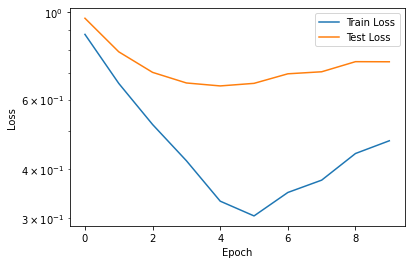

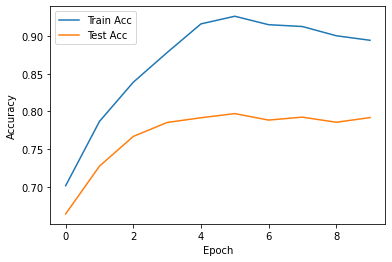

In [4]:
model = torchvision.models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)


def finetune(
    model,
    trainloader,
    testloader,
    lr=0.01,
    momentum=0.9,
    epochs=10,
    epsilon=1e-4,
    weight_decay=0.0,
):
    opt = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    loss_fn = nn.CrossEntropyLoss()

    train_loss_history = []
    test_loss_history = []
    train_acc_history = []
    test_acc_history = []

    epoch = 0
    prev_train_loss = float("inf")

    while True:
        # Train
        model.train()
        epoch_loss = 0.0
        for x, y in tqdm(trainloader, desc=f"Epoch {epoch}", leave=False):
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            loss = loss_fn(model(x), y)
            loss.backward()
            opt.step()
            epoch_loss += loss.item()

        # Eval on training set
        model.eval()
        with torch.no_grad():
            total_train_loss = 0
            total_train_correct = 0

            for x, y in trainloader:
                x, y = x.to(device), y.to(device)
                output = model(x)

                # print(x.shape, y.shape, output.shape, output, y)
                loss = loss_fn(output, y)
                total_train_loss += loss.item()
                total_train_correct += (
                    (output.max(dim=1).indices == y).sum().item()
                )  # argmax doesn't work on MPS

            avg_train_loss = total_train_loss / len(trainloader)
            avg_train_acc = total_train_correct / len(trainset)
            train_loss_history.append(avg_train_loss)
            train_acc_history.append(avg_train_acc)

            # Eval on test set
            total_test_loss = 0
            total_test_correct = 0

            for x, y in testloader:
                x, y = x.to(device), y.to(device)
                output = model(x)
                loss = loss_fn(output, y)
                total_test_loss += loss.item()
                total_test_correct += (output.max(dim=1).indices == y).sum().item()

            avg_test_loss = total_test_loss / len(testloader)
            avg_test_acc = total_test_correct / len(testset)
            test_loss_history.append(avg_test_loss)
            test_acc_history.append(avg_test_acc)

            print(
                f"Epoch: {epoch}, Train Loss: {avg_train_loss}, Test Loss: {avg_test_loss}, Train Acc: {avg_train_acc}, Test Acc: {avg_test_acc}"
            )

        # Check for convergence
        if epsilon and abs(prev_train_loss - avg_train_loss) < epsilon:
            break

        if epochs is not None and epoch >= epochs - 1:
            break

        prev_train_loss = avg_train_loss
        epoch += 1

    # Plotting
    plt.plot(train_loss_history, label="Train Loss")
    plt.plot(test_loss_history, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.yscale("log")
    plt.legend()
    plt.show()

    plt.plot(train_acc_history, label="Train Acc")
    plt.plot(test_acc_history, label="Test Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()
    return train_loss_history[-1], test_loss_history[-1], train_acc_history[-1], test_acc_history[-1]


finetune(model, trainloader, testloader, lr=0.001, weight_decay=0.1, epsilon=0.001)

In [7]:
model.to("cpu")
for i in range(10):
    rlct = estimate_learning_coeff(
        model,
        trainloader,
        nn.CrossEntropyLoss(),
        num_draws=10,
        num_chains=5,
        num_burnin_steps=0,
        num_steps_bw_draws=1,
        cores=None,
        seed=None,
        pbar=True,
        device="cpu",
    )
    print(f"Estimate {i}:", rlct)

Estimate 0: -200.52435275003157
Estimate 1: 107.82833403799926
Estimate 2: 31.13896938114366
Estimate 3: -98.27718259087783
Estimate 4: -203.6544595089611
Estimate 5: 23.884764692915923
Estimate 6: 375.3692919112746
Estimate 7: 5.790665828074265
Estimate 8: 48.30361337157306
Estimate 9: 106.12441606781152


-------------------- ResNet18 --------------------


/Users/cybershiptrooper/miniconda3/envs/devinterp/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/cybershiptrooper/miniconda3/envs/devinterp/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 0, Train Loss: 0.666263073682785, Test Loss: 0.7619410753250122, Train Acc: 0.77308, Test Acc: 0.7401


Epoch 1:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 1, Train Loss: 0.4238442074583501, Test Loss: 0.6301673047244549, Train Acc: 0.85786, Test Acc: 0.7913


Epoch 2:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 2, Train Loss: 0.3219531906806693, Test Loss: 0.6251795545220376, Train Acc: 0.89152, Test Acc: 0.795


Epoch 3:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 3, Train Loss: 0.23027640003330854, Test Loss: 0.6764838270843029, Train Acc: 0.9228, Test Acc: 0.7989


Epoch 4:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 4, Train Loss: 0.19342535171581773, Test Loss: 0.7291690796613693, Train Acc: 0.93506, Test Acc: 0.7932


Epoch 5:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 5, Train Loss: 0.1394589461614283, Test Loss: 0.7225838020443917, Train Acc: 0.95328, Test Acc: 0.807


Epoch 6:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 6, Train Loss: 0.10325642908942334, Test Loss: 0.8150498524308205, Train Acc: 0.9652, Test Acc: 0.8057


Epoch 7:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 7, Train Loss: 0.09685236629934943, Test Loss: 0.8697186067700386, Train Acc: 0.96724, Test Acc: 0.8039


Epoch 8:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 8, Train Loss: 0.07722162663442445, Test Loss: 0.8607762411236763, Train Acc: 0.97464, Test Acc: 0.8076


Epoch 9:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 9, Train Loss: 0.05407725289768102, Test Loss: 0.8687256649136543, Train Acc: 0.982, Test Acc: 0.8126


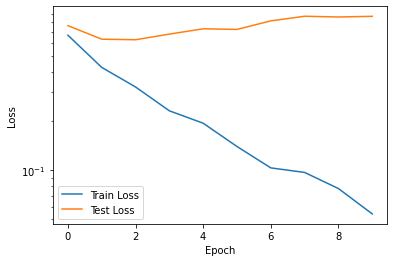

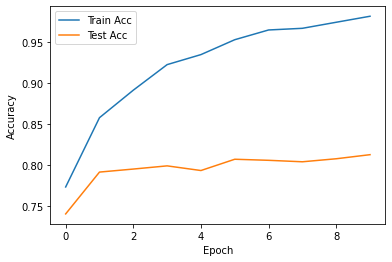

-144.4010639741258
-17.790123408103963
30.396288965050896
-------------------- ResNet34 --------------------


/Users/cybershiptrooper/miniconda3/envs/devinterp/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/cybershiptrooper/miniconda3/envs/devinterp/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /Users/cybershiptrooper/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:02<00:00, 38.5MB/s]


Epoch 0:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 0, Train Loss: 0.6060207213978378, Test Loss: 0.7123264417052269, Train Acc: 0.79472, Test Acc: 0.7592


Epoch 1:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 1, Train Loss: 0.40824913826523995, Test Loss: 0.6057106383144856, Train Acc: 0.86058, Test Acc: 0.791


Epoch 2:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 2, Train Loss: 0.28530107119253706, Test Loss: 0.5924619920551777, Train Acc: 0.90656, Test Acc: 0.8051


Epoch 3:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 3, Train Loss: 0.2041020272489713, Test Loss: 0.6322708673775196, Train Acc: 0.93142, Test Acc: 0.8089


Epoch 4:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 4, Train Loss: 0.11589642758576238, Test Loss: 0.6758613124489784, Train Acc: 0.96134, Test Acc: 0.8201


Epoch 5:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 5, Train Loss: 0.11310880669221586, Test Loss: 0.7192715801298618, Train Acc: 0.9625, Test Acc: 0.8151


Epoch 6:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 6, Train Loss: 0.07680603426558022, Test Loss: 0.7433368355035782, Train Acc: 0.97416, Test Acc: 0.8188


Epoch 7:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 7, Train Loss: 0.07336558956576854, Test Loss: 0.8094222605228424, Train Acc: 0.97514, Test Acc: 0.8131


Epoch 8:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 8, Train Loss: 0.06622195718049699, Test Loss: 0.8663751438260079, Train Acc: 0.97732, Test Acc: 0.8119


Epoch 9:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 9, Train Loss: 0.037803933233478845, Test Loss: 0.8280440777540207, Train Acc: 0.9879, Test Acc: 0.8234


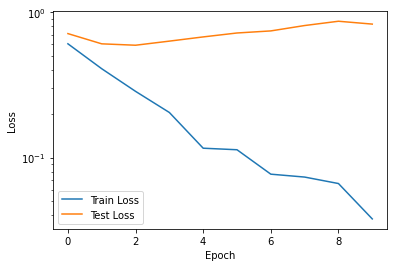

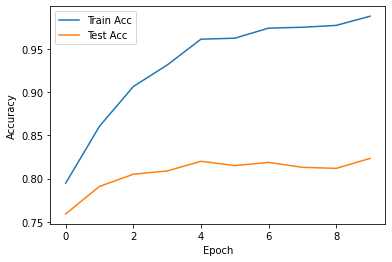

21.888359534637104
49.69124932111749
-6.914689623993903
-------------------- ResNet50 --------------------


/Users/cybershiptrooper/miniconda3/envs/devinterp/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/cybershiptrooper/miniconda3/envs/devinterp/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/cybershiptrooper/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 36.3MB/s]


Epoch 0:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 0, Train Loss: 0.5504924676248005, Test Loss: 0.6696001514792442, Train Acc: 0.81256, Test Acc: 0.7705


Epoch 1:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 1, Train Loss: 0.31945859131460286, Test Loss: 0.5624639101326465, Train Acc: 0.89322, Test Acc: 0.8049


Epoch 2:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 2, Train Loss: 0.19455128056662424, Test Loss: 0.5400005087256432, Train Acc: 0.93766, Test Acc: 0.8221


Epoch 3:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 3, Train Loss: 0.11099934121783898, Test Loss: 0.6032850600779056, Train Acc: 0.96566, Test Acc: 0.8204


Epoch 4:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 4, Train Loss: 0.08767885055240927, Test Loss: 0.6524728968739509, Train Acc: 0.97086, Test Acc: 0.8219


Epoch 5:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 5, Train Loss: 0.08019959698526227, Test Loss: 0.6942960165441037, Train Acc: 0.97242, Test Acc: 0.8275


Epoch 6:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 6, Train Loss: 0.06332761096787087, Test Loss: 0.7305641591548919, Train Acc: 0.9789, Test Acc: 0.8242


Epoch 7:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 7, Train Loss: 0.0471564192201334, Test Loss: 0.741695086658001, Train Acc: 0.98406, Test Acc: 0.8237


Epoch 8:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 8, Train Loss: 0.03501116565181589, Test Loss: 0.8051393747329711, Train Acc: 0.98844, Test Acc: 0.8291


Epoch 9:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 9, Train Loss: 0.025594835435705527, Test Loss: 0.7612130239605903, Train Acc: 0.99184, Test Acc: 0.8356


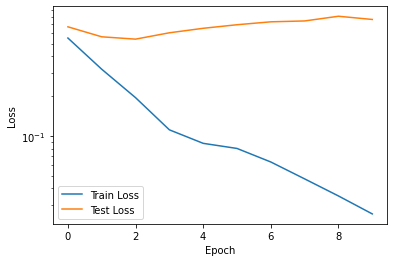

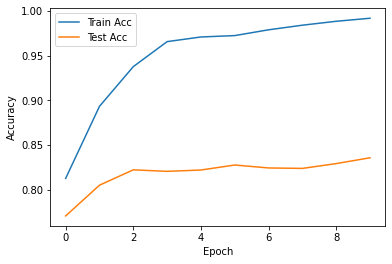

76.83581598083367
69.76173667156442
-16.050895940096794
-------------------- ResNet101 --------------------


/Users/cybershiptrooper/miniconda3/envs/devinterp/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/cybershiptrooper/miniconda3/envs/devinterp/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /Users/cybershiptrooper/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:04<00:00, 38.6MB/s] 


Epoch 0:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 0, Train Loss: 0.6015549162212683, Test Loss: 0.7264746755361557, Train Acc: 0.79228, Test Acc: 0.75


Epoch 1:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 1, Train Loss: 0.3451727730583172, Test Loss: 0.584101215004921, Train Acc: 0.88646, Test Acc: 0.7985


Epoch 2:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 2, Train Loss: 0.21264356587614333, Test Loss: 0.6121346473693847, Train Acc: 0.93298, Test Acc: 0.8016


Epoch 3:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 3, Train Loss: 0.14320148223516893, Test Loss: 0.6769061751663685, Train Acc: 0.95212, Test Acc: 0.8031


Epoch 4:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 4, Train Loss: 0.09754675588741595, Test Loss: 0.7243746653199196, Train Acc: 0.9671, Test Acc: 0.8075


Epoch 5:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 5, Train Loss: 0.059706325262632906, Test Loss: 0.7546941548585892, Train Acc: 0.9808, Test Acc: 0.8113


Epoch 6:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 6, Train Loss: 0.05784321064129472, Test Loss: 0.7928735233843327, Train Acc: 0.98044, Test Acc: 0.8112


Epoch 7:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 7, Train Loss: 0.036769643929615924, Test Loss: 0.8011051177978515, Train Acc: 0.98784, Test Acc: 0.822


Epoch 8:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 8, Train Loss: 0.02402701148791809, Test Loss: 0.8194255709648133, Train Acc: 0.9927, Test Acc: 0.8215


Epoch 9:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 9, Train Loss: 0.01902599687859112, Test Loss: 0.8688971266150475, Train Acc: 0.99438, Test Acc: 0.8243


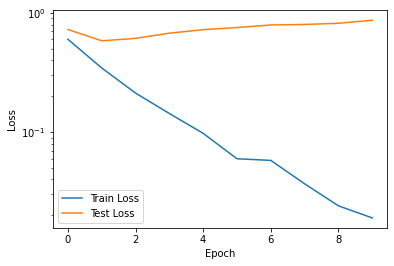

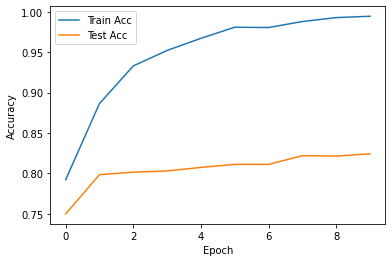

-99.60843722237817
-87.69883044155819
36.41885886621453
-------------------- ResNet152 --------------------


/Users/cybershiptrooper/miniconda3/envs/devinterp/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/cybershiptrooper/miniconda3/envs/devinterp/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /Users/cybershiptrooper/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:06<00:00, 38.1MB/s] 


Epoch 0:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 0, Train Loss: 0.7532236396658177, Test Loss: 0.8431569963693619, Train Acc: 0.74, Test Acc: 0.7095


Epoch 1:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 1, Train Loss: 0.4464089523772804, Test Loss: 0.6659904107451439, Train Acc: 0.84978, Test Acc: 0.7712


Epoch 2:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 2, Train Loss: 0.3179428706667861, Test Loss: 0.6652980297803879, Train Acc: 0.8914, Test Acc: 0.7812


Epoch 3:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 3, Train Loss: 0.16931664126411994, Test Loss: 0.6502638265490532, Train Acc: 0.94724, Test Acc: 0.7985


Epoch 4:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 4, Train Loss: 0.16421285332465657, Test Loss: 0.7543136179447174, Train Acc: 0.94436, Test Acc: 0.7813


Epoch 5:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 5, Train Loss: 0.09371721885186068, Test Loss: 0.7659351095557213, Train Acc: 0.9689, Test Acc: 0.7915


Epoch 6:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 6, Train Loss: 0.10265784708745017, Test Loss: 0.8060939222574234, Train Acc: 0.9648, Test Acc: 0.7939


Epoch 7:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 7, Train Loss: 0.04221853469878587, Test Loss: 0.8282467976212502, Train Acc: 0.98604, Test Acc: 0.8047


Epoch 8:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 8, Train Loss: 0.028534922544483324, Test Loss: 0.8783660531044006, Train Acc: 0.99118, Test Acc: 0.8065


Epoch 9:   0%|          | 0/196 [00:00<?, ?it/s]

Epoch: 9, Train Loss: 0.027865518259872893, Test Loss: 0.906803734600544, Train Acc: 0.9905, Test Acc: 0.8117


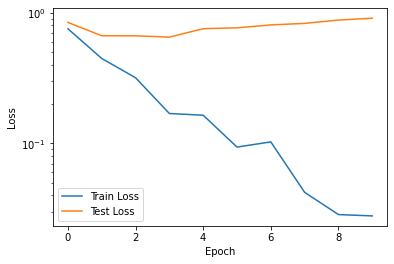

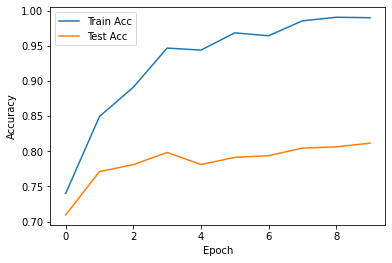

30.633915940398406
-8.197156556780584
8.29271662955813


In [8]:
rlcts = []
resnet_depths = [18, 34, 50, 101, 152]
train_losses = []
test_losses = []
for num_layers in resnet_depths:
    print("-" * 20 + f" ResNet{num_layers} " + "-" * 20)
    model_name = f"resnet{num_layers}"
    model = getattr(torchvision.models, model_name)(pretrained=True).to(device)
    checkpoint_folder = f"../checkpoints/resnet-finetuned-cifar/"
    checkpoint_full_path = checkpoint_folder + f"{model_name}.pt"

    if os.path.exists(checkpoint_full_path):
        print("Loading from checkpoint")
        model.load_state_dict(torch.load(checkpoint_full_path))
    else:
        train_loss, test_loss, _, _ = finetune(model, trainloader=trainloader, testloader=testloader)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        if not os.path.exists(checkpoint_folder):
            os.makedirs(checkpoint_folder)
        torch.save(model.state_dict(), checkpoint_full_path)

    _rlcts = []
    model.to("cpu")
    for i in range(3):
        _rlct = estimate_learning_coeff(
            model,
            trainloader,
            nn.CrossEntropyLoss(),
            sampling_method=SGLD,
            num_draws=100,
            num_chains=3,
            num_burnin_steps=0,
            num_steps_bw_draws=1,
            optimizer_kwargs={"elasticity": 100},
            cores=None,
            seed=None,
            pbar=True,
            device="cpu",
        )
        _rlcts.append(_rlct)
        print(_rlct)

    rlcts.append(_rlcts)

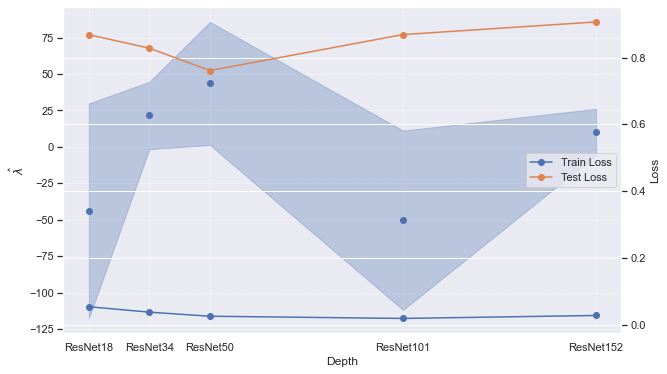

In [19]:
sns.set()

blue = sns.color_palette()[0]

resnet_depths = [18, 34, 50, 101, 152]

# Names for the different ResNet architectures
arch_names = ["ResNet18", "ResNet34", "ResNet50", "ResNet101" , "ResNet152"]

# Calculate means and standard deviations
means = [np.mean(_rlcts) for _rlcts in rlcts]
stds = [np.std(_rlcts) for _rlcts in rlcts]

# Calculate error bounds
lower_bounds = [mean - std for mean, std in zip(means, stds)]
upper_bounds = [mean + std for mean, std in zip(means, stds)]

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the scatter points for the means
plt.scatter(resnet_depths, means, color=blue, label=r"Mean $\hat\lambda$", zorder=2)

# Plot the transparent area chart for the error bars
plt.fill_between(
    resnet_depths,
    lower_bounds,
    upper_bounds,
    color=blue,
    alpha=0.3,
    label=r"Std $\hat\lambda$",
)
plt.xlabel("Depth")
plt.ylabel(r"$\hat\lambda$")
plt.xticks(resnet_depths, arch_names)
plt.grid(True, linestyle="--", linewidth=0.5)

# plot train/test loss using the following values
if train_losses == [] or test_losses == []:
    train_losses = [0.05407725289768102, 0.037803933233478845, 0.025594835435705527, 0.01902599687859112, 0.027865518259872893]
    test_losses = [0.8687256649136543, 0.8280440777540207, 0.7612130239605903, 0.8688971266150475, 0.906803734600544]
# plot
ax2 = plt.twinx()
ax2.plot(resnet_depths, train_losses, marker='o', label='Train Loss')
ax2.plot(resnet_depths, test_losses, marker='o', label='Test Loss')
ax2.set_ylabel('Loss')
plt.legend()

# Show the plot
plt.show()

In [ ]:
# Resnet18: Train Loss: 0.05407725289768102, Test Loss: 0.8687256649136543
# Resnet34: Train Loss: 0.037803933233478845, Test Loss: 0.8280440777540207
# Resnet50: Train Loss: 0.025594835435705527, Test Loss: 0.7612130239605903
# Resnet101: Train Loss: 0.01902599687859112, Test Loss: 0.8688971266150475
# Resnet152: Train Loss: 0.027865518259872893, Test Loss: 0.906803734600544

In [12]:
means

[-43.93163280572629,
 21.554973077253564,
 43.51555223743376,
 -50.29613626590728,
 10.243158671058652]